<a href="https://colab.research.google.com/github/Many98/real_estate/blob/models/notebooks/XGboost_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import max_error
from sklearn.metrics import median_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [153]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('test_dataset.csv', sep=',', delimiter=None, encoding="utf8")

df.drop(columns=df.columns[0], axis=1, inplace=True) 

ok_cols = df.columns.difference(["note", "description", "hash", "name", "desc_hash", 
                                 "floor_area", "geometry", "place" ,"tags",
                                 "additional_disposition", "transport","header",
                                 "date"]+ [i for i in df.columns if '_txt' in i])

df = df[ok_cols]

df['price_m2'] = df["price"]/df["usable_area"]
 


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (367,385,388,389,391,392) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [122]:
df.columns

Index(['air_quality_1.0', 'air_quality_2.0', 'air_quality_3.0',
       'air_quality_4.0', 'air_quality_5.0', 'air_quality_ord',
       'air_quality_unknown', 'atm_dist_0-99m', 'atm_dist_100-199m',
       'atm_dist_1000-1099m',
       ...
       'year_reconstruction_2021-2025', 'year_reconstruction_<1950',
       'year_reconstruction_num', 'year_reconstruction_ord',
       'year_reconstruction_undefined', 'price_m2', 'gp_ci_high_price_2',
       'gp_ci_low_price_2', 'gp_mean_price_2', 'gp_std_price_2'],
      dtype='object', length=726)

In [298]:
# columns with embeddings
only_embeddings = [i for i in df.columns if 'emb' in i]

# only ordinal columns 
only_ord = [i for i in df.columns if 'ord' in i]

# columns with ordinal distance
only_ord_dist = [i for i in df.columns if 'dist' in i and 'ord' in i and 'num' not in i]

# only numerical dist columns (with indicator >=1500m)
only_num_dist = [i for i in df.columns if 'dist' in i and 'ord' not in i and 'num' in i] + \
                [i for i in df.columns if '1500m' in i]

# only one-hot encoded distances
only_one_hot_dist = [i for i in df.columns if 'dist' in i and 'ord' not in i and
                     'num' not in i]

# only coordinates
only_coords = ['long', 'lat']

# Gaussian process predicition
only_gp = [i for i in df.columns if 'gp' in i]

# noise
only_noise = [i for i in df.columns if 'noise' in i]

# quality
only_quality_ord = [i for i in df.columns if ('quality' in i or
                'sun' in i or 'built' in i) and 'ord' in i]

# one hotncoded energy effeciency
only_energy = [i for i in df.columns if 'energy_effeciency' in i and 'ord' not in i]


# disposition
only_disposition = [i for i in df.columns if 'disposition' in i]

# ownership
only_ownership = [i for i in df.columns if 'ownership' in i]

# only has_<> features
only_has = [i for i in df.columns if 'has' in i]

In [299]:
print(only_embeddings)
print(only_ord)
print(only_ord_dist)
print(only_num_dist)
print(only_one_hot_dist)
print(only_gp)
print(only_noise)
print(only_quality_ord)
print(only_disposition)
print(only_ownership)
print(only_energy)
print(only_has)

# e.g. when u want columns without embeddings and without ordinal features and without
#one-hot encoded ditances do something like that

df1 = df[df.columns.difference(only_embeddings + only_ord + only_one_hot_dist)]

['ft_emb_1', 'ft_emb_10', 'ft_emb_100', 'ft_emb_101', 'ft_emb_102', 'ft_emb_103', 'ft_emb_104', 'ft_emb_105', 'ft_emb_106', 'ft_emb_107', 'ft_emb_108', 'ft_emb_109', 'ft_emb_11', 'ft_emb_110', 'ft_emb_111', 'ft_emb_112', 'ft_emb_113', 'ft_emb_114', 'ft_emb_115', 'ft_emb_116', 'ft_emb_117', 'ft_emb_118', 'ft_emb_119', 'ft_emb_12', 'ft_emb_120', 'ft_emb_121', 'ft_emb_122', 'ft_emb_123', 'ft_emb_124', 'ft_emb_125', 'ft_emb_126', 'ft_emb_127', 'ft_emb_128', 'ft_emb_129', 'ft_emb_13', 'ft_emb_130', 'ft_emb_131', 'ft_emb_132', 'ft_emb_133', 'ft_emb_134', 'ft_emb_135', 'ft_emb_136', 'ft_emb_137', 'ft_emb_138', 'ft_emb_139', 'ft_emb_14', 'ft_emb_140', 'ft_emb_141', 'ft_emb_142', 'ft_emb_143', 'ft_emb_144', 'ft_emb_145', 'ft_emb_146', 'ft_emb_147', 'ft_emb_148', 'ft_emb_149', 'ft_emb_15', 'ft_emb_150', 'ft_emb_151', 'ft_emb_152', 'ft_emb_153', 'ft_emb_154', 'ft_emb_155', 'ft_emb_156', 'ft_emb_157', 'ft_emb_158', 'ft_emb_159', 'ft_emb_16', 'ft_emb_160', 'ft_emb_161', 'ft_emb_162', 'ft_emb_163', 

In [297]:
df1[df1.price_m2 < 10000]

,air_quality_1.0,air_quality_2.0,air_quality_3.0,air_quality_4.0,air_quality_5.0,air_quality_unknown,atm_dist_num,built_density_1.0,built_density_2.0,built_density_3.0,built_density_4.0,built_density_5.0,built_density_unknown,bus_station_dist_num,construction_type_Cihlová,construction_type_Drevostavba,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Panelová,construction_type_Skeletová,construction_type_Smíšená,construction_type_unknown,daily_noise,disposition_1+1,disposition_1+kk,disposition_2+1,disposition_2+kk,disposition_3+1,disposition_3+kk,disposition_4+1,disposition_4+kk,disposition_5+1,disposition_5+kk,disposition_6+kk,disposition_6_pokojů_a_více,disposition_atypické,disposition_unknown,doctor_dist_num,electricity_False,electricity_True,electricity_unknown,energy_effeciency_A,energy_effeciency_B,energy_effeciency_C,energy_effeciency_D,energy_effeciency_E,energy_effeciency_F,energy_effeciency_G,energy_effeciency_unknown,equipment_ano,equipment_ne,equipment_unknown,equipment_Částečně,floor,gas_False,gas_True,gas_unknown,gp_ci_high_price,gp_ci_low_price,gp_mean_price,gp_std_price,has_balcony,has_cellar,has_garage,has_garden,has_lift,has_loggia,has_parking,heating_False,heating_True,heating_unknown,kindergarten_dist_num,lat,long,nightly_noise,no_barriers,ownership_Družstevní,ownership_Osobní,ownership_Státní/obecní,ownership_unknown,park_dist_num,pharmacy_dist_num,playground_dist_num,post_office_dist_num,price,price_m2,primary_school_dist_num,restaurant_pub_dist_num,sports_field_dist_num,state_Dobrý,state_Novostavba,state_Po_rekonstrukci,state_Projekt,state_Před_rekonstrukcí,state_V_rekonstrukci,state_Ve_výstavbě,state_Velmi_dobrý,state_unknown,state_Špatný,subway_station_dist_num,sun_glare_1.0,sun_glare_2.0,sun_glare_3.0,sun_glare_4.0,sun_glare_5.0,sun_glare_unknown,supermarket_grocery_dist_num,telecomunication_False,telecomunication_True,telecomunication_unknown,theatre_cinema_dist_num,train_station_dist_num,tram_station_dist_num,usable_area,vet_dist_num,waste_False,waste_True,waste_unknown,year_reconstruction_1951-1980,year_reconstruction_1981-2000,year_reconstruction_2001-2010,year_reconstruction_2011-2015,year_reconstruction_2016-2020,year_reconstruction_2021-2025,year_reconstruction_<1950,year_reconstruction_num,year_reconstruction_undefined
5829,0.0,0.0,0.0,0.0,1.0,0.0,145.000000,0.0,0.0,0.0,0.0,1.0,0.0,155.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2254.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,178217.892646,53505.473867,115861.683257,31178.104695,True,True,False,False,False,False,False,0.0,1.0,0.0,153.000000,50.035912,14.411921,60.0,True,0.0,1.0,0.0,0.0,255.408120,327.000000,282.000000,67.000000,25000.0,438.596491,186.000000,192.000000,268.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2536.00000,0.0,0.0,0.0,0.0,1.0,0.0,184.000000,0.0,1.0,0.0,93.000000,1112.000000,294.000000,57.0,122.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6130,0.0,0.0,0.0,1.0,0.0,0.0,207.000000,0.0,0.0,0.0,1.0,0.0,0.0,358.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,65.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,377.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,186147.179637,61795.596316,123971.387977,31087.895830,False,False,False,False,True,False,False,0.0,0.0,1.0,94.000000,50.111725,14.495926,65.0,True,0.0,1.0,0.0,0.0,200.378447,130.000000,202.000000,415.000000,7210000.0,5077.464789,328.000000,205.000000,159.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,292.00000,0.0,0.0,0.0,1.0,0.0,0.0,398.000000,0.0,0.0,1.0,737.000000,137.000000,251.000000,1420.0,648.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7209,0.0,0.0,0.0,1.0,0.0,0.0,105.583296,0.0,0.0,0.0,1.0,0.0,0.0,81.111336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,60.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,575.061206,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.

In [13]:
df1.columns

Index(['additional_disposition', 'air_quality_1.0', 'air_quality_2.0',
       'air_quality_3.0', 'air_quality_4.0', 'air_quality_5.0',
       'air_quality_unknown', 'atm_dist_num', 'built_density_1.0',
       'built_density_2.0',
       ...
       'waste_unknown', 'year_reconstruction_1951-1980',
       'year_reconstruction_1981-2000', 'year_reconstruction_2001-2010',
       'year_reconstruction_2011-2015', 'year_reconstruction_2016-2020',
       'year_reconstruction_2021-2025', 'year_reconstruction_<1950',
       'year_reconstruction_num', 'year_reconstruction_undefined'],
      dtype='object', length=138)

In [ ]:
df.describe()

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní/obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1+kk,disposition_1+1,disposition_3+1,disposition_3+kk,disposition_2+kk,disposition_4+1,disposition_2+1,disposition_5+kk,disposition_4+kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5+1,disposition_6+kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_<1950,year_reconstruction_1951-1980,year_reconstruction_1981-2000,year_reconstruction_2001-2010,year_reconstruction_2011-2015,year_reconstruction_2016-2020,year_reconstruction_2021-2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1.0,air_quality_2.0,air_quality_3.0,air_quality_4.0,air_quality_5.0,built_density_unknown,built_density_1.0,built_density_2.0,built_density_3.0,built_density_4.0,built_density_5.0,sun_glare_unknown,sun_glare_1.0,sun_glare_2.0,sun_glare_3.0,sun_glare_4.0,sun_glare_5.0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist_>=1500m,bus_station_dist_0-99m,bus_station_dist_100-199m,bus_station_dist_200-299m,bus_station_dist_300-399m,bus_station_dist_400-499m,bus_station_dist_500-599m,bus_station_dist_600-699m,bus_station_dist_700-799m,bus_station_dist_800-899m,bus_station_dist_900-999m,bus_station_dist_1000-1099m,bus_station_dist_1100-1199m,bus_station_dist_1200-1299m,bus_station_dist_1300-1399m,bus_station_dist_1400-1499m,train_station_dist_>=1500m,train_station_dist_0-99m,train_station_dist_100-199m,train_station_dist_200-299m,train_station_dist_300-399m,train_station_dist_400-499m,train_station_dist_500-599m,train_station_dist_600-699m,train_station_dist_700-799m,train_station_dist_800-899m,train_station_dist_900-999m,train_station_dist_1000-1099m,train_station_dist_1100-1199m,train_station_dist_1200-1299m,train_station_dist_1300-1399m,train_station_dist_1400-1499m,subway_station_dist_>=1500m,subway_station_dist_0-99m,subway_station_dist_100-199m,subway_station_dist_200-299m,subway_station_dist_300-399m,subway_station_dist_400-499m,subway_station_dist_500-599m,subway_station_dist_600-699m,subway_station_dist_700-799m,subway_station_dist_800-899m,subway_station_dist_900-999m,subway_station_dist_1000-1099m,subway_station_dist_1100-1199m,subway_station_dist_1200-1299m,subway_station_dist_1300-1399m,subway_station_dist_1400-1499m,tram_station_dist_>=1500m,tram_station_dist_0-99m,tram_station_dist_100-199m,tram_station_dist_200-299m,tram_station_dist_300-399m,tram_station_dist_400-499m,tram_station_dist_500-599m,tram_station_dist_600-699m,tram_station_dist_700-799m,tram_station_dist_800-899m,tram_station_dist_900-999m,tram_station_dist_1000-1099m,tram_station_dist_1100-1199m,tram_station_dist_1200-1299m,tram_station_dist_1300-1399m,tram_station_dist_1400-1499m,post_office_dist_>=1500m,post_office_dist_0-99m,post_office_dist_100-199m,post_office_dist_200-299m,post_office_dist_300-399m,post_office_dist_400-499m,post_office_dist_500-599m,post_office_dist_600-699m,post_office_dist_700-799m,post_office_dist_800-899m,post_office_dist_900-999m,post_office_dist_1000-1099m,post_office_dist_1100-1199m,post_office_dist_1200-1299m,post_office_dist_1300-1399m,post_office_dist_1400-1499m,atm_dist_

In [ ]:
df.head()

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní/obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1+kk,disposition_1+1,disposition_3+1,disposition_3+kk,disposition_2+kk,disposition_4+1,disposition_2+1,disposition_5+kk,disposition_4+kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5+1,disposition_6+kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_<1950,year_reconstruction_1951-1980,year_reconstruction_1981-2000,year_reconstruction_2001-2010,year_reconstruction_2011-2015,year_reconstruction_2016-2020,year_reconstruction_2021-2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1.0,air_quality_2.0,air_quality_3.0,air_quality_4.0,air_quality_5.0,built_density_unknown,built_density_1.0,built_density_2.0,built_density_3.0,built_density_4.0,built_density_5.0,sun_glare_unknown,sun_glare_1.0,sun_glare_2.0,sun_glare_3.0,sun_glare_4.0,sun_glare_5.0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist_>=1500m,bus_station_dist_0-99m,bus_station_dist_100-199m,bus_station_dist_200-299m,bus_station_dist_300-399m,bus_station_dist_400-499m,bus_station_dist_500-599m,bus_station_dist_600-699m,bus_station_dist_700-799m,bus_station_dist_800-899m,bus_station_dist_900-999m,bus_station_dist_1000-1099m,bus_station_dist_1100-1199m,bus_station_dist_1200-1299m,bus_station_dist_1300-1399m,bus_station_dist_1400-1499m,train_station_dist_>=1500m,train_station_dist_0-99m,train_station_dist_100-199m,train_station_dist_200-299m,train_station_dist_300-399m,train_station_dist_400-499m,train_station_dist_500-599m,train_station_dist_600-699m,train_station_dist_700-799m,train_station_dist_800-899m,train_station_dist_900-999m,train_station_dist_1000-1099m,train_station_dist_1100-1199m,train_station_dist_1200-1299m,train_station_dist_1300-1399m,train_station_dist_1400-1499m,subway_station_dist_>=1500m,subway_station_dist_0-99m,subway_station_dist_100-199m,subway_station_dist_200-299m,subway_station_dist_300-399m,subway_station_dist_400-499m,subway_station_dist_500-599m,subway_station_dist_600-699m,subway_station_dist_700-799m,subway_station_dist_800-899m,subway_station_dist_900-999m,subway_station_dist_1000-1099m,subway_station_dist_1100-1199m,subway_station_dist_1200-1299m,subway_station_dist_1300-1399m,subway_station_dist_1400-1499m,tram_station_dist_>=1500m,tram_station_dist_0-99m,tram_station_dist_100-199m,tram_station_dist_200-299m,tram_station_dist_300-399m,tram_station_dist_400-499m,tram_station_dist_500-599m,tram_station_dist_600-699m,tram_station_dist_700-799m,tram_station_dist_800-899m,tram_station_dist_900-999m,tram_station_dist_1000-1099m,tram_station_dist_1100-1199m,tram_station_dist_1200-1299m,tram_station_dist_1300-1399m,tram_station_dist_1400-1499m,post_office_dist_>=1500m,post_office_dist_0-99m,post_office_dist_100-199m,post_office_dist_200-299m,post_office_dist_300-399m,post_office_dist_400-499m,post_office_dist_500-599m,post_office_dist_600-699m,post_office_dist_700-799m,post_office_dist_800-899m,post_office_dist_900-999m,post_office_dist_1000-1099m,post_office_dist_1100-1199m,post_office_dist_1200-1299m,post_office_dist_1300-1399m,post_office_dist_1400-1499m,atm_dist_

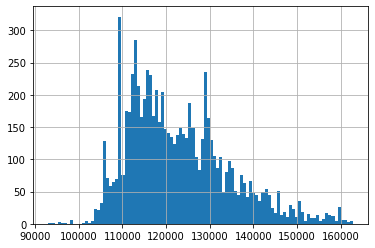

In [ ]:
hist = df["gp_mean_price"].hist(bins=100)

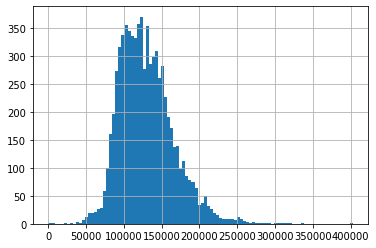

In [ ]:
hist = df["price_m2"].hist(bins=100)

In [ ]:
fig = px.box(df, y="gp_mean_price")
fig.show()

In [ ]:
fig = px.box(df, y="price_m2")
fig.show()


In [ ]:
df[df.price_m2 < 35000] # byty za 25000 a 23000 jenom? - Prodej podílu 1/345 bytu 3+kk 57 m² - inzerát: https://www.sreality.cz/hledani/prodej/byty/praha?cena-od=0&cena-do=25000

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní/obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1+kk,disposition_1+1,disposition_3+1,disposition_3+kk,disposition_2+kk,disposition_4+1,disposition_2+1,disposition_5+kk,disposition_4+kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5+1,disposition_6+kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_<1950,year_reconstruction_1951-1980,year_reconstruction_1981-2000,year_reconstruction_2001-2010,year_reconstruction_2011-2015,year_reconstruction_2016-2020,year_reconstruction_2021-2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1.0,air_quality_2.0,air_quality_3.0,air_quality_4.0,air_quality_5.0,built_density_unknown,built_density_1.0,built_density_2.0,built_density_3.0,built_density_4.0,built_density_5.0,sun_glare_unknown,sun_glare_1.0,sun_glare_2.0,sun_glare_3.0,sun_glare_4.0,sun_glare_5.0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist_>=1500m,bus_station_dist_0-99m,bus_station_dist_100-199m,bus_station_dist_200-299m,bus_station_dist_300-399m,bus_station_dist_400-499m,bus_station_dist_500-599m,bus_station_dist_600-699m,bus_station_dist_700-799m,bus_station_dist_800-899m,bus_station_dist_900-999m,bus_station_dist_1000-1099m,bus_station_dist_1100-1199m,bus_station_dist_1200-1299m,bus_station_dist_1300-1399m,bus_station_dist_1400-1499m,train_station_dist_>=1500m,train_station_dist_0-99m,train_station_dist_100-199m,train_station_dist_200-299m,train_station_dist_300-399m,train_station_dist_400-499m,train_station_dist_500-599m,train_station_dist_600-699m,train_station_dist_700-799m,train_station_dist_800-899m,train_station_dist_900-999m,train_station_dist_1000-1099m,train_station_dist_1100-1199m,train_station_dist_1200-1299m,train_station_dist_1300-1399m,train_station_dist_1400-1499m,subway_station_dist_>=1500m,subway_station_dist_0-99m,subway_station_dist_100-199m,subway_station_dist_200-299m,subway_station_dist_300-399m,subway_station_dist_400-499m,subway_station_dist_500-599m,subway_station_dist_600-699m,subway_station_dist_700-799m,subway_station_dist_800-899m,subway_station_dist_900-999m,subway_station_dist_1000-1099m,subway_station_dist_1100-1199m,subway_station_dist_1200-1299m,subway_station_dist_1300-1399m,subway_station_dist_1400-1499m,tram_station_dist_>=1500m,tram_station_dist_0-99m,tram_station_dist_100-199m,tram_station_dist_200-299m,tram_station_dist_300-399m,tram_station_dist_400-499m,tram_station_dist_500-599m,tram_station_dist_600-699m,tram_station_dist_700-799m,tram_station_dist_800-899m,tram_station_dist_900-999m,tram_station_dist_1000-1099m,tram_station_dist_1100-1199m,tram_station_dist_1200-1299m,tram_station_dist_1300-1399m,tram_station_dist_1400-1499m,post_office_dist_>=1500m,post_office_dist_0-99m,post_office_dist_100-199m,post_office_dist_200-299m,post_office_dist_300-399m,post_office_dist_400-499m,post_office_dist_500-599m,post_office_dist_600-699m,post_office_dist_700-799m,post_office_dist_800-899m,post_office_dist_900-999m,post_office_dist_1000-1099m,post_office_dist_1100-1199m,post_office_dist_1200-1299m,post_office_dist_1300-1399m,post_office_dist_1400-1499m,atm_dist_

In [ ]:
df.drop([df.index[5829] , df.index[7209]], inplace = True)
fig = px.box(df, y="price_m2")
fig.show()

In [ ]:
df[df.price_m2 > 400000] # https://www.sreality.cz/detail/prodej/byt/2+kk/praha-vysocany-podebradska/4035192396 - chyba v inzerátu

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní/obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1+kk,disposition_1+1,disposition_3+1,disposition_3+kk,disposition_2+kk,disposition_4+1,disposition_2+1,disposition_5+kk,disposition_4+kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5+1,disposition_6+kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_<1950,year_reconstruction_1951-1980,year_reconstruction_1981-2000,year_reconstruction_2001-2010,year_reconstruction_2011-2015,year_reconstruction_2016-2020,year_reconstruction_2021-2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1.0,air_quality_2.0,air_quality_3.0,air_quality_4.0,air_quality_5.0,built_density_unknown,built_density_1.0,built_density_2.0,built_density_3.0,built_density_4.0,built_density_5.0,sun_glare_unknown,sun_glare_1.0,sun_glare_2.0,sun_glare_3.0,sun_glare_4.0,sun_glare_5.0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist_>=1500m,bus_station_dist_0-99m,bus_station_dist_100-199m,bus_station_dist_200-299m,bus_station_dist_300-399m,bus_station_dist_400-499m,bus_station_dist_500-599m,bus_station_dist_600-699m,bus_station_dist_700-799m,bus_station_dist_800-899m,bus_station_dist_900-999m,bus_station_dist_1000-1099m,bus_station_dist_1100-1199m,bus_station_dist_1200-1299m,bus_station_dist_1300-1399m,bus_station_dist_1400-1499m,train_station_dist_>=1500m,train_station_dist_0-99m,train_station_dist_100-199m,train_station_dist_200-299m,train_station_dist_300-399m,train_station_dist_400-499m,train_station_dist_500-599m,train_station_dist_600-699m,train_station_dist_700-799m,train_station_dist_800-899m,train_station_dist_900-999m,train_station_dist_1000-1099m,train_station_dist_1100-1199m,train_station_dist_1200-1299m,train_station_dist_1300-1399m,train_station_dist_1400-1499m,subway_station_dist_>=1500m,subway_station_dist_0-99m,subway_station_dist_100-199m,subway_station_dist_200-299m,subway_station_dist_300-399m,subway_station_dist_400-499m,subway_station_dist_500-599m,subway_station_dist_600-699m,subway_station_dist_700-799m,subway_station_dist_800-899m,subway_station_dist_900-999m,subway_station_dist_1000-1099m,subway_station_dist_1100-1199m,subway_station_dist_1200-1299m,subway_station_dist_1300-1399m,subway_station_dist_1400-1499m,tram_station_dist_>=1500m,tram_station_dist_0-99m,tram_station_dist_100-199m,tram_station_dist_200-299m,tram_station_dist_300-399m,tram_station_dist_400-499m,tram_station_dist_500-599m,tram_station_dist_600-699m,tram_station_dist_700-799m,tram_station_dist_800-899m,tram_station_dist_900-999m,tram_station_dist_1000-1099m,tram_station_dist_1100-1199m,tram_station_dist_1200-1299m,tram_station_dist_1300-1399m,tram_station_dist_1400-1499m,post_office_dist_>=1500m,post_office_dist_0-99m,post_office_dist_100-199m,post_office_dist_200-299m,post_office_dist_300-399m,post_office_dist_400-499m,post_office_dist_500-599m,post_office_dist_600-699m,post_office_dist_700-799m,post_office_dist_800-899m,post_office_dist_900-999m,post_office_dist_1000-1099m,post_office_dist_1100-1199m,post_office_dist_1200-1299m,post_office_dist_1300-1399m,post_office_dist_1400-1499m,atm_dist_

In [ ]:
df.drop([df.index[3202]], inplace = True)
fig = px.box(df, y="price_m2")
fig.show()

In [ ]:
fig = px.box(df, y="price") # doesn't tell us about outliers, because of usable area
fig.show()
df[df.price > 120000000]

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní/obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1+kk,disposition_1+1,disposition_3+1,disposition_3+kk,disposition_2+kk,disposition_4+1,disposition_2+1,disposition_5+kk,disposition_4+kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5+1,disposition_6+kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_<1950,year_reconstruction_1951-1980,year_reconstruction_1981-2000,year_reconstruction_2001-2010,year_reconstruction_2011-2015,year_reconstruction_2016-2020,year_reconstruction_2021-2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1.0,air_quality_2.0,air_quality_3.0,air_quality_4.0,air_quality_5.0,built_density_unknown,built_density_1.0,built_density_2.0,built_density_3.0,built_density_4.0,built_density_5.0,sun_glare_unknown,sun_glare_1.0,sun_glare_2.0,sun_glare_3.0,sun_glare_4.0,sun_glare_5.0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist_>=1500m,bus_station_dist_0-99m,bus_station_dist_100-199m,bus_station_dist_200-299m,bus_station_dist_300-399m,bus_station_dist_400-499m,bus_station_dist_500-599m,bus_station_dist_600-699m,bus_station_dist_700-799m,bus_station_dist_800-899m,bus_station_dist_900-999m,bus_station_dist_1000-1099m,bus_station_dist_1100-1199m,bus_station_dist_1200-1299m,bus_station_dist_1300-1399m,bus_station_dist_1400-1499m,train_station_dist_>=1500m,train_station_dist_0-99m,train_station_dist_100-199m,train_station_dist_200-299m,train_station_dist_300-399m,train_station_dist_400-499m,train_station_dist_500-599m,train_station_dist_600-699m,train_station_dist_700-799m,train_station_dist_800-899m,train_station_dist_900-999m,train_station_dist_1000-1099m,train_station_dist_1100-1199m,train_station_dist_1200-1299m,train_station_dist_1300-1399m,train_station_dist_1400-1499m,subway_station_dist_>=1500m,subway_station_dist_0-99m,subway_station_dist_100-199m,subway_station_dist_200-299m,subway_station_dist_300-399m,subway_station_dist_400-499m,subway_station_dist_500-599m,subway_station_dist_600-699m,subway_station_dist_700-799m,subway_station_dist_800-899m,subway_station_dist_900-999m,subway_station_dist_1000-1099m,subway_station_dist_1100-1199m,subway_station_dist_1200-1299m,subway_station_dist_1300-1399m,subway_station_dist_1400-1499m,tram_station_dist_>=1500m,tram_station_dist_0-99m,tram_station_dist_100-199m,tram_station_dist_200-299m,tram_station_dist_300-399m,tram_station_dist_400-499m,tram_station_dist_500-599m,tram_station_dist_600-699m,tram_station_dist_700-799m,tram_station_dist_800-899m,tram_station_dist_900-999m,tram_station_dist_1000-1099m,tram_station_dist_1100-1199m,tram_station_dist_1200-1299m,tram_station_dist_1300-1399m,tram_station_dist_1400-1499m,post_office_dist_>=1500m,post_office_dist_0-99m,post_office_dist_100-199m,post_office_dist_200-299m,post_office_dist_300-399m,post_office_dist_400-499m,post_office_dist_500-599m,post_office_dist_600-699m,post_office_dist_700-799m,post_office_dist_800-899m,post_office_dist_900-999m,post_office_dist_1000-1099m,post_office_dist_1100-1199m,post_office_dist_1200-1299m,post_office_dist_1300-1399m,post_office_dist_1400-1499m,atm_dist_

In [ ]:
df[df.price < 2000000]

,daily_noise,nightly_noise,energy_effeciency_unknown,energy_effeciency_G,energy_effeciency_E,energy_effeciency_B,energy_effeciency_D,energy_effeciency_C,energy_effeciency_A,energy_effeciency_F,ownership_Osobní,ownership_Státní/obecní,ownership_Družstevní,ownership_unknown,equipment_unknown,equipment_ne,equipment_Částečně,equipment_ano,state_unknown,state_V_rekonstrukci,state_Před_rekonstrukcí,state_Po_rekonstrukci,state_Novostavba,state_Velmi_dobrý,state_Dobrý,state_Ve_výstavbě,state_Projekt,state_Špatný,disposition_unknown,disposition_1+kk,disposition_1+1,disposition_3+1,disposition_3+kk,disposition_2+kk,disposition_4+1,disposition_2+1,disposition_5+kk,disposition_4+kk,disposition_atypické,disposition_6_pokojů_a_více,disposition_5+1,disposition_6+kk,construction_type_unknown,construction_type_Cihlová,construction_type_Smíšená,construction_type_Panelová,construction_type_Skeletová,construction_type_Kamenná,construction_type_Montovaná,construction_type_Nízkoenergetická,construction_type_Drevostavba,year_reconstruction_<1950,year_reconstruction_1951-1980,year_reconstruction_1981-2000,year_reconstruction_2001-2010,year_reconstruction_2011-2015,year_reconstruction_2016-2020,year_reconstruction_2021-2025,year_reconstruction_undefined,air_quality_unknown,air_quality_1.0,air_quality_2.0,air_quality_3.0,air_quality_4.0,air_quality_5.0,built_density_unknown,built_density_1.0,built_density_2.0,built_density_3.0,built_density_4.0,built_density_5.0,sun_glare_unknown,sun_glare_1.0,sun_glare_2.0,sun_glare_3.0,sun_glare_4.0,sun_glare_5.0,gas_unknown,gas_True,gas_False,waste_unknown,waste_True,waste_False,telecomunication_unknown,telecomunication_True,telecomunication_False,electricity_unknown,electricity_True,electricity_False,heating_unknown,heating_True,heating_False,bus_station_dist_>=1500m,bus_station_dist_0-99m,bus_station_dist_100-199m,bus_station_dist_200-299m,bus_station_dist_300-399m,bus_station_dist_400-499m,bus_station_dist_500-599m,bus_station_dist_600-699m,bus_station_dist_700-799m,bus_station_dist_800-899m,bus_station_dist_900-999m,bus_station_dist_1000-1099m,bus_station_dist_1100-1199m,bus_station_dist_1200-1299m,bus_station_dist_1300-1399m,bus_station_dist_1400-1499m,train_station_dist_>=1500m,train_station_dist_0-99m,train_station_dist_100-199m,train_station_dist_200-299m,train_station_dist_300-399m,train_station_dist_400-499m,train_station_dist_500-599m,train_station_dist_600-699m,train_station_dist_700-799m,train_station_dist_800-899m,train_station_dist_900-999m,train_station_dist_1000-1099m,train_station_dist_1100-1199m,train_station_dist_1200-1299m,train_station_dist_1300-1399m,train_station_dist_1400-1499m,subway_station_dist_>=1500m,subway_station_dist_0-99m,subway_station_dist_100-199m,subway_station_dist_200-299m,subway_station_dist_300-399m,subway_station_dist_400-499m,subway_station_dist_500-599m,subway_station_dist_600-699m,subway_station_dist_700-799m,subway_station_dist_800-899m,subway_station_dist_900-999m,subway_station_dist_1000-1099m,subway_station_dist_1100-1199m,subway_station_dist_1200-1299m,subway_station_dist_1300-1399m,subway_station_dist_1400-1499m,tram_station_dist_>=1500m,tram_station_dist_0-99m,tram_station_dist_100-199m,tram_station_dist_200-299m,tram_station_dist_300-399m,tram_station_dist_400-499m,tram_station_dist_500-599m,tram_station_dist_600-699m,tram_station_dist_700-799m,tram_station_dist_800-899m,tram_station_dist_900-999m,tram_station_dist_1000-1099m,tram_station_dist_1100-1199m,tram_station_dist_1200-1299m,tram_station_dist_1300-1399m,tram_station_dist_1400-1499m,post_office_dist_>=1500m,post_office_dist_0-99m,post_office_dist_100-199m,post_office_dist_200-299m,post_office_dist_300-399m,post_office_dist_400-499m,post_office_dist_500-599m,post_office_dist_600-699m,post_office_dist_700-799m,post_office_dist_800-899m,post_office_dist_900-999m,post_office_dist_1000-1099m,post_office_dist_1100-1199m,post_office_dist_1200-1299m,post_office_dist_1300-1399m,post_office_dist_1400-1499m,atm_dist_

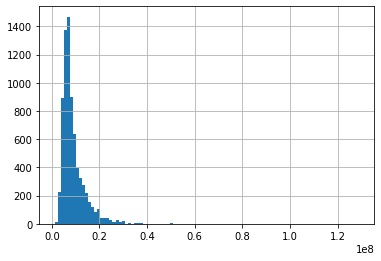

In [ ]:
hist = df["price"].hist(bins=100)

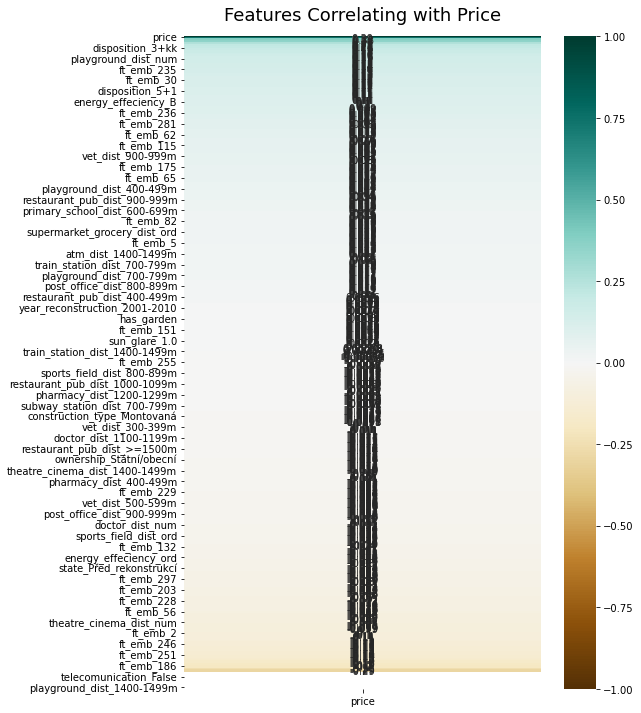

In [ ]:
df.corr()[['price']].sort_values(by='price', ascending=False)
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':18}, pad=16);

In [346]:
df_final = df[['price', 'usable_area', 'price_m2']
              +only_gp
              +only_coords
              +only_energy
              +only_disposition
              +only_ownership
              #+only_num_dist
              #+only_ord_dist
              #+only_has
              #+only_embeddings
              ].copy()  # here set final df

#df_final = df_final[(df_final.price_m2 < 380000)]

df_final = df_final[df_final.columns.difference(['price_m2'])]

df_final.columns = df_final.columns.str.replace(r'.', '_')
df_final.columns = df_final.columns.str.replace(r'-', '_')
df_final.columns = df_final.columns.str.replace(r'>=', '_vetsi_rovno_')
df_final.columns = df_final.columns.str.replace(r'+', '_plus_')
df_final.columns = df_final.columns.str.replace(r' ', '_')
df_final.columns = df_final.columns.str.replace(r'/', '_')
df_final.columns = df_final.columns.str.replace(r'[', '_')
df_final.columns = df_final.columns.str.replace(r']', '_')
df_final.columns = df_final.columns.str.replace(r'<', 'mensi')

df_final.columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular ex

Index(['disposition_1_plus_1', 'disposition_1_plus_kk', 'disposition_2_plus_1',
       'disposition_2_plus_kk', 'disposition_3_plus_1',
       'disposition_3_plus_kk', 'disposition_4_plus_1',
       'disposition_4_plus_kk', 'disposition_5_plus_1',
       'disposition_5_plus_kk', 'disposition_6_plus_kk',
       'disposition_6_pokojů_a_více', 'disposition_atypické',
       'disposition_unknown', 'energy_effeciency_A', 'energy_effeciency_B',
       'energy_effeciency_C', 'energy_effeciency_D', 'energy_effeciency_E',
       'energy_effeciency_F', 'energy_effeciency_G',
       'energy_effeciency_unknown', 'gp_ci_high_price', 'gp_ci_low_price',
       'gp_mean_price', 'gp_std_price', 'lat', 'long', 'ownership_Družstevní',
       'ownership_Osobní', 'ownership_Státní_obecní', 'ownership_unknown',
       'price', 'usable_area'],
      dtype='object')

#XGboost

In [344]:
y = df_final['price'].values.reshape(-1,1)

X = df_final[df_final.columns.difference(['price'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, shuffle=True)

In [238]:
X_train.shape

(5965, 6)

In [35]:
duplicate_columns = X.columns[X.columns.duplicated()]
duplicate_columns


Index([], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7454 entries, 0 to 7456
Columns: 721 entries, daily_noise to sun_glare_ord
dtypes: bool(8), float64(694), int64(19)
memory usage: 40.7 MB


In [345]:
# squared_error  
# TODO it uses squared error we need to use absolute error but colab does not have it
model = XGBRegressor(n_estimators = 60,
                     learning_rate=0.099, 
                     colsample_bytree=0.99,
                     max_depth=3,
                     random_state=42, silent=True, booster='gbtree')
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

print("The model training score is " , model.score(X_train, y_train))
print("The model testing score is " , model.score(X_test, y_test))
print("The model testing mean absolute error is ", mean_absolute_error(y_test, y_pred))
print("The model max error is ", max_error(y_test, y_pred))
print("The model median absolute error is ", median_absolute_error(y_test, y_pred))

The model training score is  0.86279359754429
The model testing score is  0.8331221015282756
The model testing mean absolute error is  1357898.9028150134
The model max error is  20237915.0
The model median absolute error is  881070.0
